# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [1]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from torch.nn import Softmax
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS
from isaac.evaluation import predict_with_a_group_of_saved_models, evaluate_saved_model
from isaac.statistical_tests import z_test

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm


In [2]:
INTERVAL_SIZE = 1
FPS = 60
STEP_SIZE = 3
PD_STEP_SIZE = 10
SEQ_END = 2700

In [3]:
device = get_cuda_device_if_available()
print(device)

cuda:0


In [4]:
RTHETA_ATTRS = [obj+"."+attr for obj in ["o1", "o2", "o3", "o4"] for attr in ["r", "theta"]]
XY_RTHETA_ATTRS = [obj+"."+attr for obj in ["o1", "o2", "o3", "o4"] for attr in ["x", 'y', "r", "theta"]]
XY_VXVY_RTHETA_ATTRS = [obj+"."+attr for obj in ["o1", "o2", "o3", "o4"] for attr in ["x", 'y', "vx", "vy", "r", "theta"]]

In [5]:
normalise_data = True
scaler_path = "scalers/passive_xy_rtheta_scaler.sk"
network_dims = (len(XY_RTHETA_ATTRS), 25, 3, 0.5)
dataset_path = "../new_exp_data/exp7_passive_rtheta.h5"
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
multiclass = True
DATASET = read_dataset(dataset_path)


def get_question_predictions_for_group_of_models(question_type):    
    models = sorted(glob.glob("models/xy_r_theta/best_"+question_type+"_model_seed_*.pt"))

    group_predictions = []
    
    predictions = predict_with_a_group_of_saved_models(tqdm(models), network_dims, None, 
                                                       training_columns=XY_RTHETA_ATTRS, 
                                                       class_columns=class_columns, step_size=STEP_SIZE, 
                                                       seq_end=SEQ_END, scaler_path=scaler_path,
                                                       arch=MultiBranchModel, multiclass=multiclass, trials=DATASET,
                                                       predict_seq2seq=True)

    predictions = torch.stack(predictions)
    
    print(predictions.shape)
    if question_type == "mass":
        predictions = predictions[:, :, :, 0]
    else:
        predictions = predictions[:, :, :, 1]

    return predictions

def get_question_accuracy_for_group_of_models(question_type):    
    model_paths = tqdm(sorted(glob.glob("models/xy_r_theta/best_"+question_type+"_model_seed_*.pt")))

    accuracies, predicted = evaluate_saved_model(model_paths, network_dims, dataset_path, 
                                                 training_columns=XY_RTHETA_ATTRS, class_columns=class_columns, 
                                                 step_size=STEP_SIZE, seq_end=SEQ_END, scaler_path=scaler_path,
                                                 arch=MultiBranchModel, multiclass=multiclass, trials=None)
    
    if question_type == "mass":
        question_index = 0
    else:
        question_index = 1

    accuracies = np.stack(accuracies)[:, question_index]
    
    predicted = [x[:, question_index].numpy() for x in predicted]

    return accuracies, predicted


def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

# T-test for MASS questions

## Load model's predictions

In [6]:
print("MASS")
question_type = "mass"
group_mass_seq_prediction = get_question_predictions_for_group_of_models(question_type)

print("\nFORCE")
question_type = "force"
group_force_seq_prediction = get_question_predictions_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([25, 36, 45, 2, 3])

FORCE


100%|██████████| 25/25 [00:19<00:00,  1.50it/s]

torch.Size([25, 36, 45, 2, 3])


In [7]:
mass_solutions = [trial[list(MASS_CLASS_COLS)].idxmax(axis=1).unique()[0] for trial in DATASET]
force_solutions = [trial[list(FORCE_CLASS_COLS)].idxmax(axis=1).unique()[0] for trial in DATASET]

In [8]:
s = Softmax(dim=-1)
group_force_seq_prediction = s(group_force_seq_prediction)
group_mass_seq_prediction = s(group_mass_seq_prediction)

In [9]:
sim_second = [i for _ in range(25) for _ in range(36) for i in range(1, 46)]
model_seed = [i for i in range(25) for _ in range(36) for _ in range(1, 46)]
trial_number = [i for _ in range(25) for i in range(36) for _ in range(1, 46)]

In [10]:
mass_df = pd.DataFrame(data=group_mass_seq_prediction.reshape(40500, 3).numpy(), 
                       columns=["rnn_%s" % cl for cl in MASS_CLASS_COLS])
mass_df["sim_second"] = sim_second
mass_df["model_seed"] = model_seed
mass_df["trial_number"] = trial_number
mass_df["solution"] = [mass_solutions[trial_id] for trial_id in trial_number]

force_df = pd.DataFrame(data=group_force_seq_prediction.reshape(40500, 3).numpy(), 
                       columns=["rnn_%s" % cl for cl in FORCE_CLASS_COLS])
force_df["sim_second"] = sim_second
force_df["model_seed"] = model_seed
force_df["trial_number"] = trial_number
force_df["solution"] = [force_solutions[trial_id] for trial_id in trial_number]

from scipy.stats import mode

print("MASS")
question_type = "mass"
mass_accuracies, group_mass_prediction = get_question_accuracy_for_group_of_models(question_type)

print("\nFORCE")
question_type = "force"
force_accuracies, group_force_prediction = get_question_accuracy_for_group_of_models(question_type)

mode_mass_prediction = mode(np.stack(group_mass_prediction), axis=0)[0][0]
mode_force_prediction = mode(np.stack(group_force_prediction), axis=0)[0][0]

In [11]:
mass_solution_probability = []
force_solution_probability = []

for row in tqdm(range(force_df.shape[0])):
    force_solution = force_df.iloc[row].solution
    force_solution_probability.append(force_df.iloc[row]["rnn_%s" % force_solution])
    
    mass_solution = mass_df.iloc[row].solution
    mass_solution_probability.append(mass_df.iloc[row]["rnn_%s" % mass_solution])

100%|██████████| 40500/40500 [00:27<00:00, 1473.21it/s]


In [12]:
mass_df["solution_probability"] = mass_solution_probability
force_df["solution_probability"] = force_solution_probability

## Load human results

In [13]:
import glob
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

trials_pd_paths = sorted(glob.glob("../new_exp_data/pd_summaries/pd_summaries/cv*tt*.rdata"))

trial_pds = []

for path in trials_pd_paths:
    r['load'](path)
    trial = r['df.ext']
    trial.frame = np.arange(10, 2710, 10).tolist() * 4
    trial_pds.append(trial)    

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWa

In [14]:
from scipy.stats import spearmanr

In [15]:
mass_pd_list = []
force_pd_list = []

for trial_pd in trial_pds:

    window_size = int(FPS * INTERVAL_SIZE / PD_STEP_SIZE)
    
    pd_mass = trial_pd[["frame", "pd.mass.rtheta"]].groupby("frame").agg({"pd.mass.rtheta": np.mean})
    pd_mass = pd_mass["pd.mass.rtheta"].rolling(window=window_size).mean().values[window_size-1::window_size]
    mass_pd_list.append(pd_mass)

    pd_force = trial_pd[["frame", "pd.rel.rtheta"]].groupby("frame").agg({"pd.rel.rtheta": np.mean})
    pd_force = pd_force["pd.rel.rtheta"].rolling(window=window_size).mean().values[window_size-1::window_size]
    force_pd_list.append(pd_force)

In [16]:
def get_correlation_and_solutions_per_trial(rnn_df, pd_list):

    all_models_and_trials = []
    trials_correlations = []
    trials_solutions = []

    for trial_id, pd_series in tqdm(enumerate(pd_list), total=36):
        this_trial_probabilities = []

        for model_seed in rnn_df.model_seed.unique():
            this_model_and_trial_df = rnn_df[(rnn_df.model_seed == model_seed) & (rnn_df.trial_number == trial_id)].copy()
            this_model_and_trial_df["pd"] = pd_series
            all_models_and_trials.append(this_model_and_trial_df)

            this_trial_probabilities.append(this_model_and_trial_df["solution_probability"])
            
            
        trials_solutions.append(this_model_and_trial_df.solution.unique()[0])
        trials_correlations.append(spearmanr(pd_series, np.mean(this_trial_probabilities, axis=0))[0])

    all_models_and_trials = pd.concat(all_models_and_trials)
    corr_df = pd.DataFrame(data={"solution": trials_solutions, "correlation":trials_correlations,
                                "trial_number": np.arange(0, 36)})

    return all_models_and_trials, corr_df

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)
sns.set_style("white")

In [18]:
plt.rc('font', weight='bold')

100%|██████████| 36/36 [00:01<00:00, 25.89it/s]


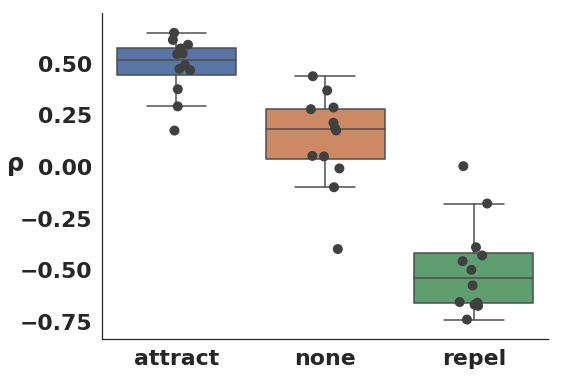

100%|██████████| 36/36 [00:01<00:00, 26.60it/s]


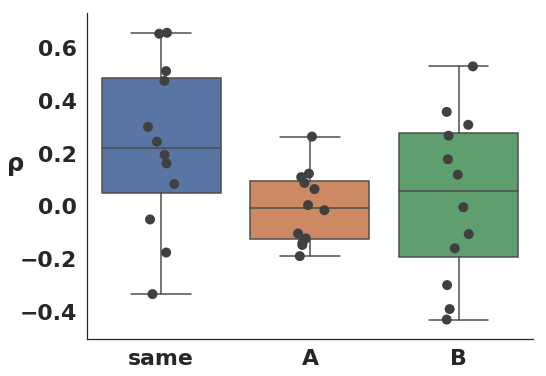

In [19]:
force_models_and_trials, force_corr_df = get_correlation_and_solutions_per_trial(force_df, force_pd_list)
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="solution", y="correlation", data=force_corr_df, showfliers = False)
ax = sns.stripplot(x="solution", y="correlation", data=force_corr_df, color=".25", size=10)
sns.despine(ax=ax)
ax.set(xlabel=None)
ax.set(ylabel="ρ")
plt.ylabel("ρ", rotation=0, weight="bold")
plt.savefig("cogsci_images/force_corr_PD.pdf", bbox_inches="tight", dpi=1200)
plt.show()

mass_models_and_trials, mass_corr_df = get_correlation_and_solutions_per_trial(mass_df, mass_pd_list)
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="solution", y="correlation", data=mass_corr_df, showfliers = False)
ax = sns.stripplot(x="solution", y="correlation", data=mass_corr_df, color=".25", size=10)
sns.despine(ax=ax)
ax.set(xlabel=None)
ax.set(ylabel="ρ")
plt.ylabel("ρ", rotation=0, weight="bold")
plt.savefig("cogsci_images/mass_corr_PD.pdf",  bbox_inches="tight", dpi=1200)

In [20]:
force_corr_df.groupby("solution").correlation.median()

solution
attract    0.520290
none       0.182345
repel     -0.536298
Name: correlation, dtype: float64

In [21]:
from isaac.visualization import make_frame_curried
import moviepy.editor as mpy

def make_clip(trial_data):

    duration = len(trial_data)

    n_bodies = sum(["o"+str(i)+".x" in list(trial_data.columns) for i in range(1, 5)])
    
    while (len(trial_data) + 1) % 60 != 0:
        trial_data = trial_data.append(trial_data.iloc[-1], ignore_index=True)
    make_frame = make_frame_curried(trial_data, n_bodies)
    clip = mpy.VideoClip(make_frame, duration=duration / 60)
    return clip, trial_data

replays = read_dataset("../new_exp_data/exp7_passive.h5")
clips = [make_clip(replay)[0] for replay in replays]

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [22]:
force_corr_df = force_corr_df.sort_values(by=["solution", "correlation"], ascending=False)
mass_corr_df = mass_corr_df.sort_values(by=["solution", "correlation"], ascending=False)

In [23]:
def plot_single_figure(trial_df, ax=None, single=False, savepath=None, corr=0):
    if single:
        plt.figure(figsize=(8, 6))

    trial_pd = trial_df.groupby("sim_second").pd.mean().values

    ax = sns.lineplot(y="solution_probability", x="sim_second", data=trial_df, ax=ax, linewidth=3, label="RNN")
    sns.despine(ax=ax)
    trial_pd = trial_df.groupby("sim_second").pd.mean().values
    ax.plot(trial_pd, linewidth=3, label="IO")
    
    if single:
        plt.title("ρ =  %.3f" % corr, weight="bold")
        plt.xlabel("Time (s)", weight="bold")
        plt.yticks([0, 0.25, 0.5, 0.75])
        plt.ylabel("Probability", weight="bold")
        plt.legend(loc="upper left", prop={"size": "small", 'weight':'bold'})
        plt.savefig(savepath, bbox_inches='tight')
    
    return ax

def plot_appendix_figure(corr_df, model_and_trials_df):

    nrows = 12
    ncols = 36 // nrows
    f, axis = plt.subplots(nrows, ncols, figsize=(25, 40), sharex=True, sharey=True)

    for i, trial_id in enumerate(corr_df.trial_number):
        row = i // nrows
        col = i % nrows

        trial_df = model_and_trials_df[model_and_trials_df.trial_number == trial_id]

        ax = plot_single_figure(trial_df, axis[col][row])

        title = "Corr: %.3f" % (corr_df[corr_df.trial_number == trial_id].correlation.unique()[0])
        if col == 0:
            title = trial_df.solution.unique()[0] + "\n" + title

        ax.set_title(title)

    plt.show()

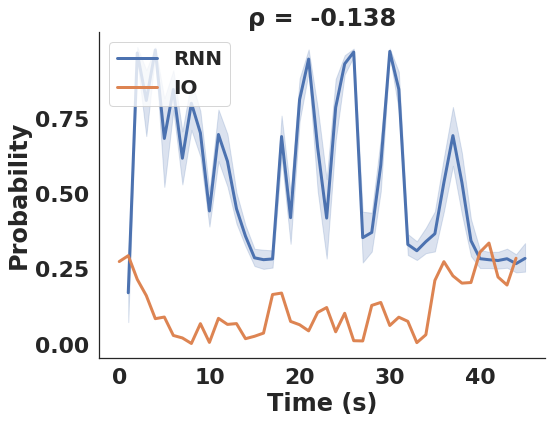

In [24]:
plot_single_figure(mass_models_and_trials[mass_models_and_trials.trial_number == mass_corr_df.iloc[33].trial_number],
                   single=True, savepath="cogsci_images/PD_RNN_prob_mass_plot.pdf", 
                   corr=mass_corr_df.iloc[33].correlation)

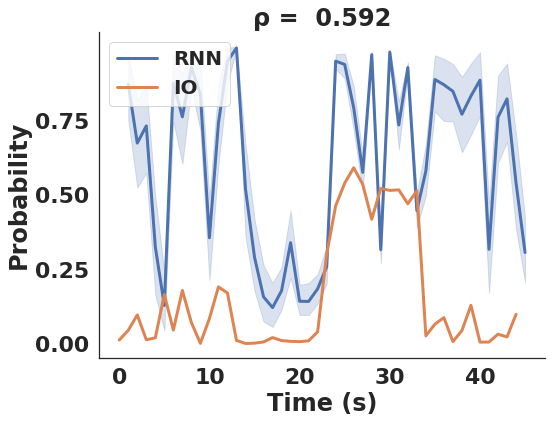

In [25]:
plot_single_figure(force_models_and_trials[force_models_and_trials.trial_number == force_corr_df.iloc[26].trial_number],
                   single=True, savepath="cogsci_images/PD_RNN_prob_force_plot.pdf",
                  corr=force_corr_df.iloc[26].correlation)

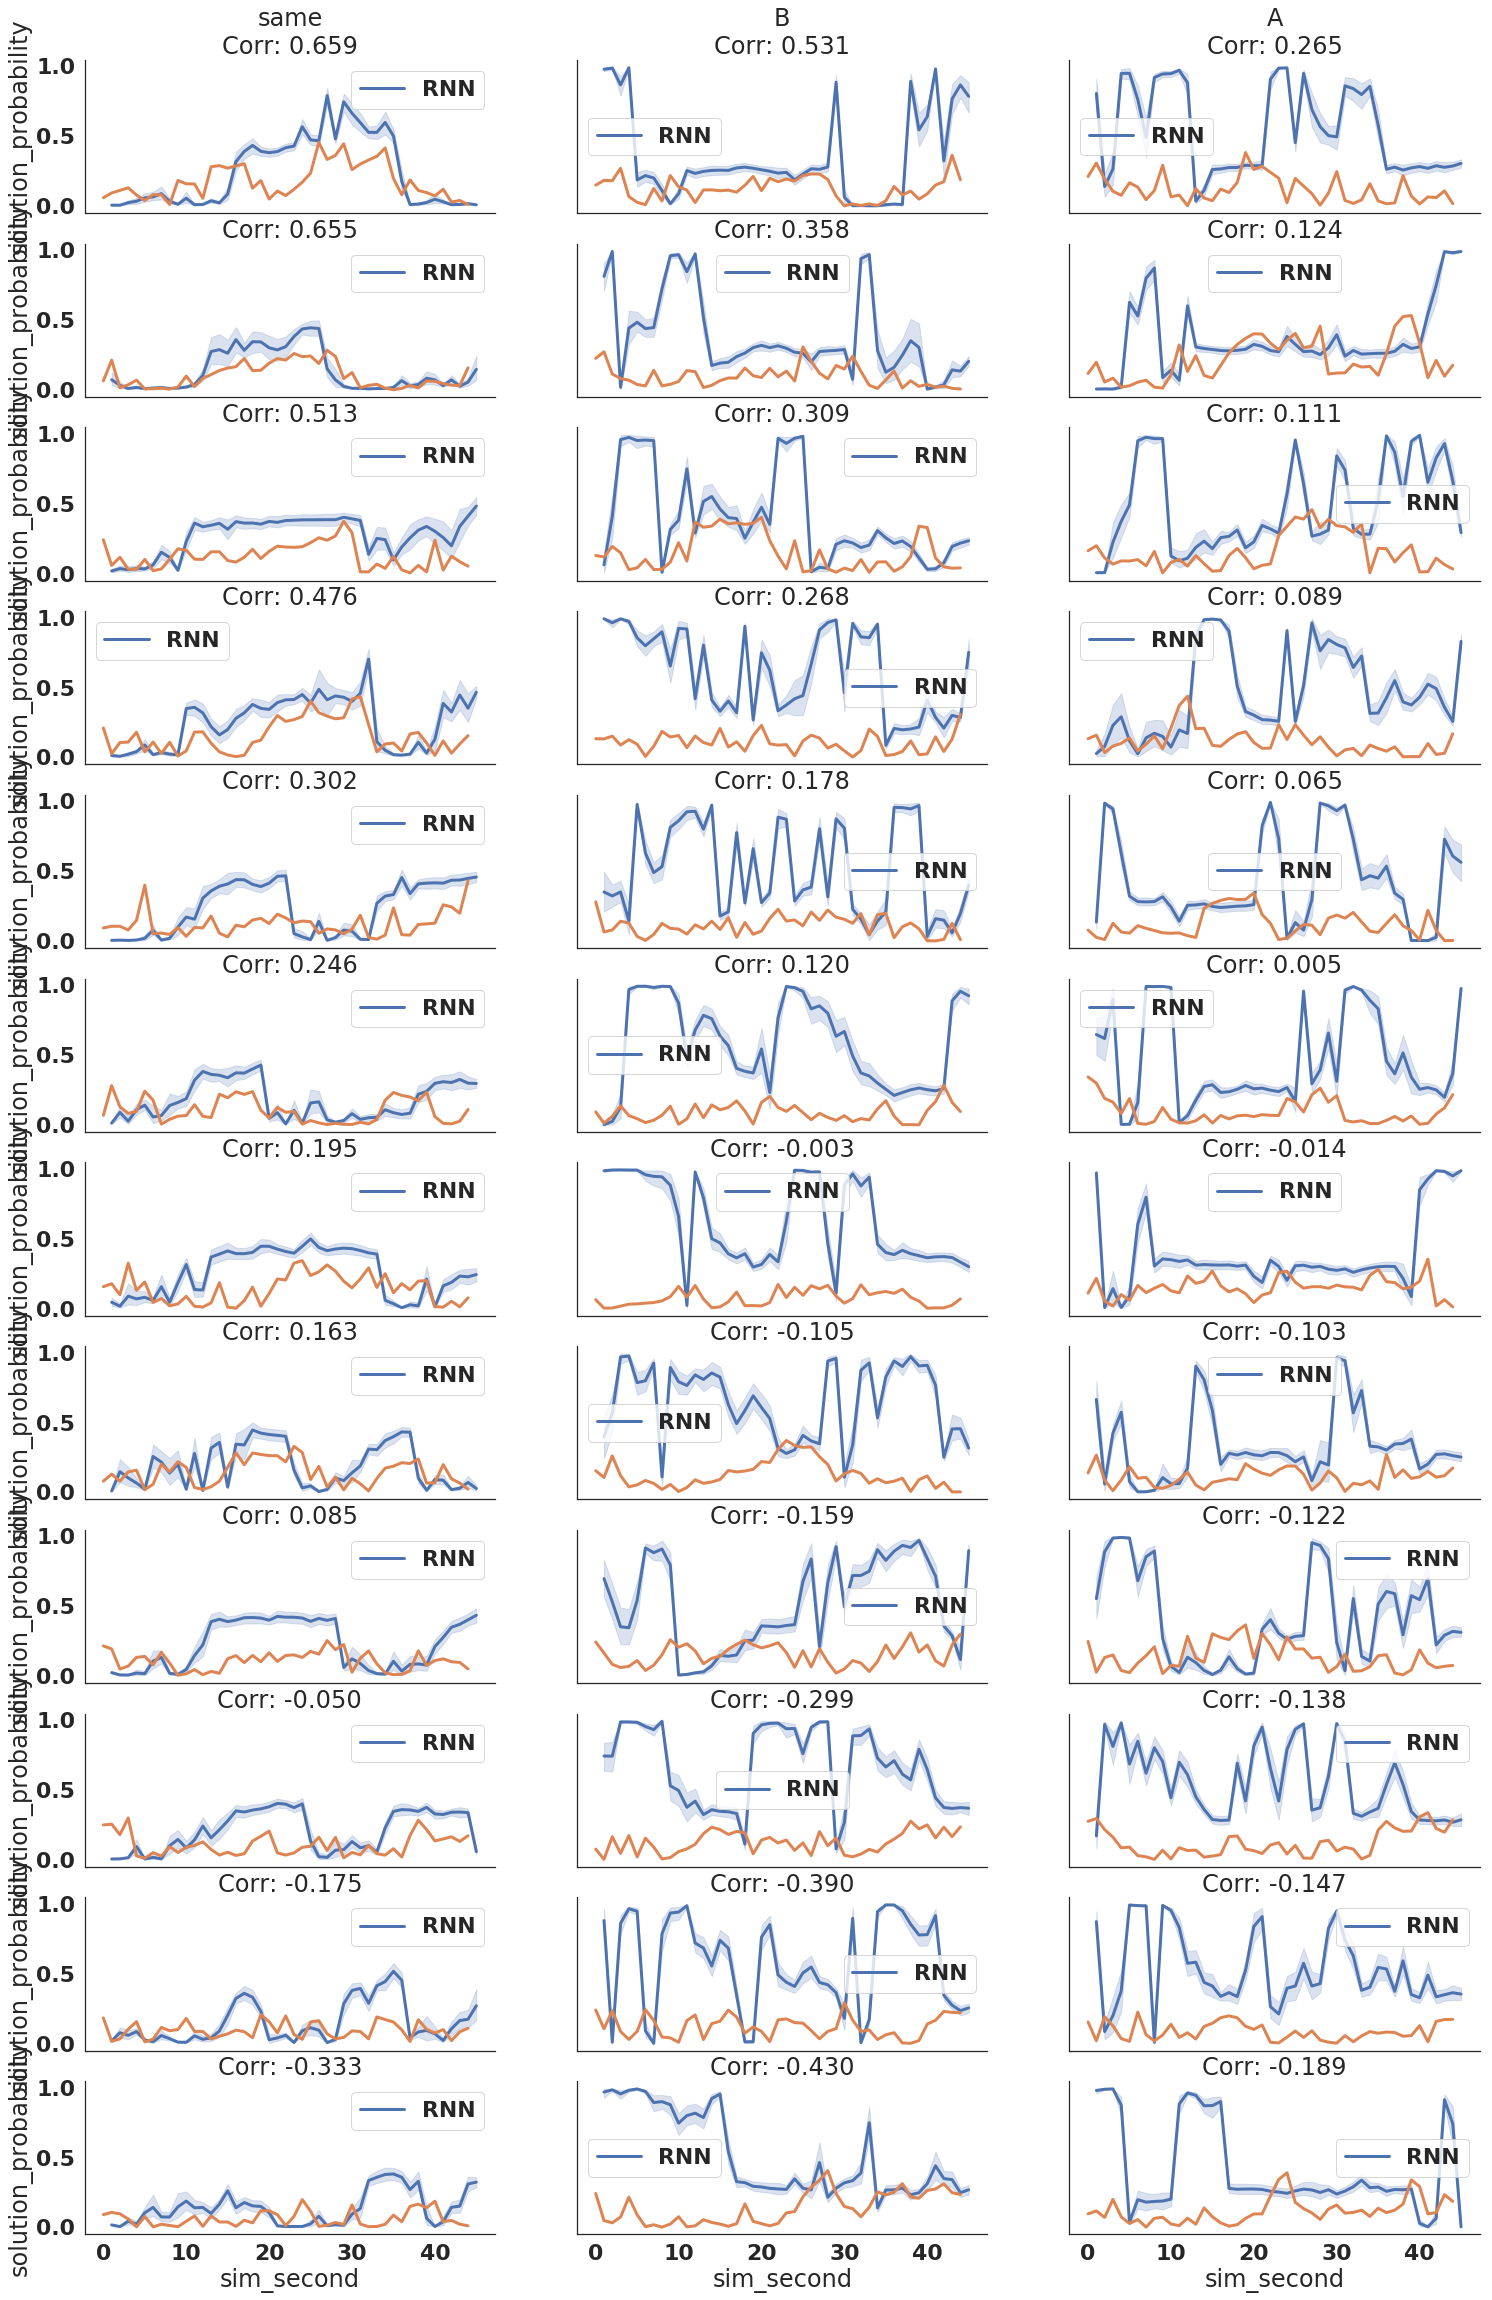

In [26]:
plot_appendix_figure(mass_corr_df, mass_models_and_trials)

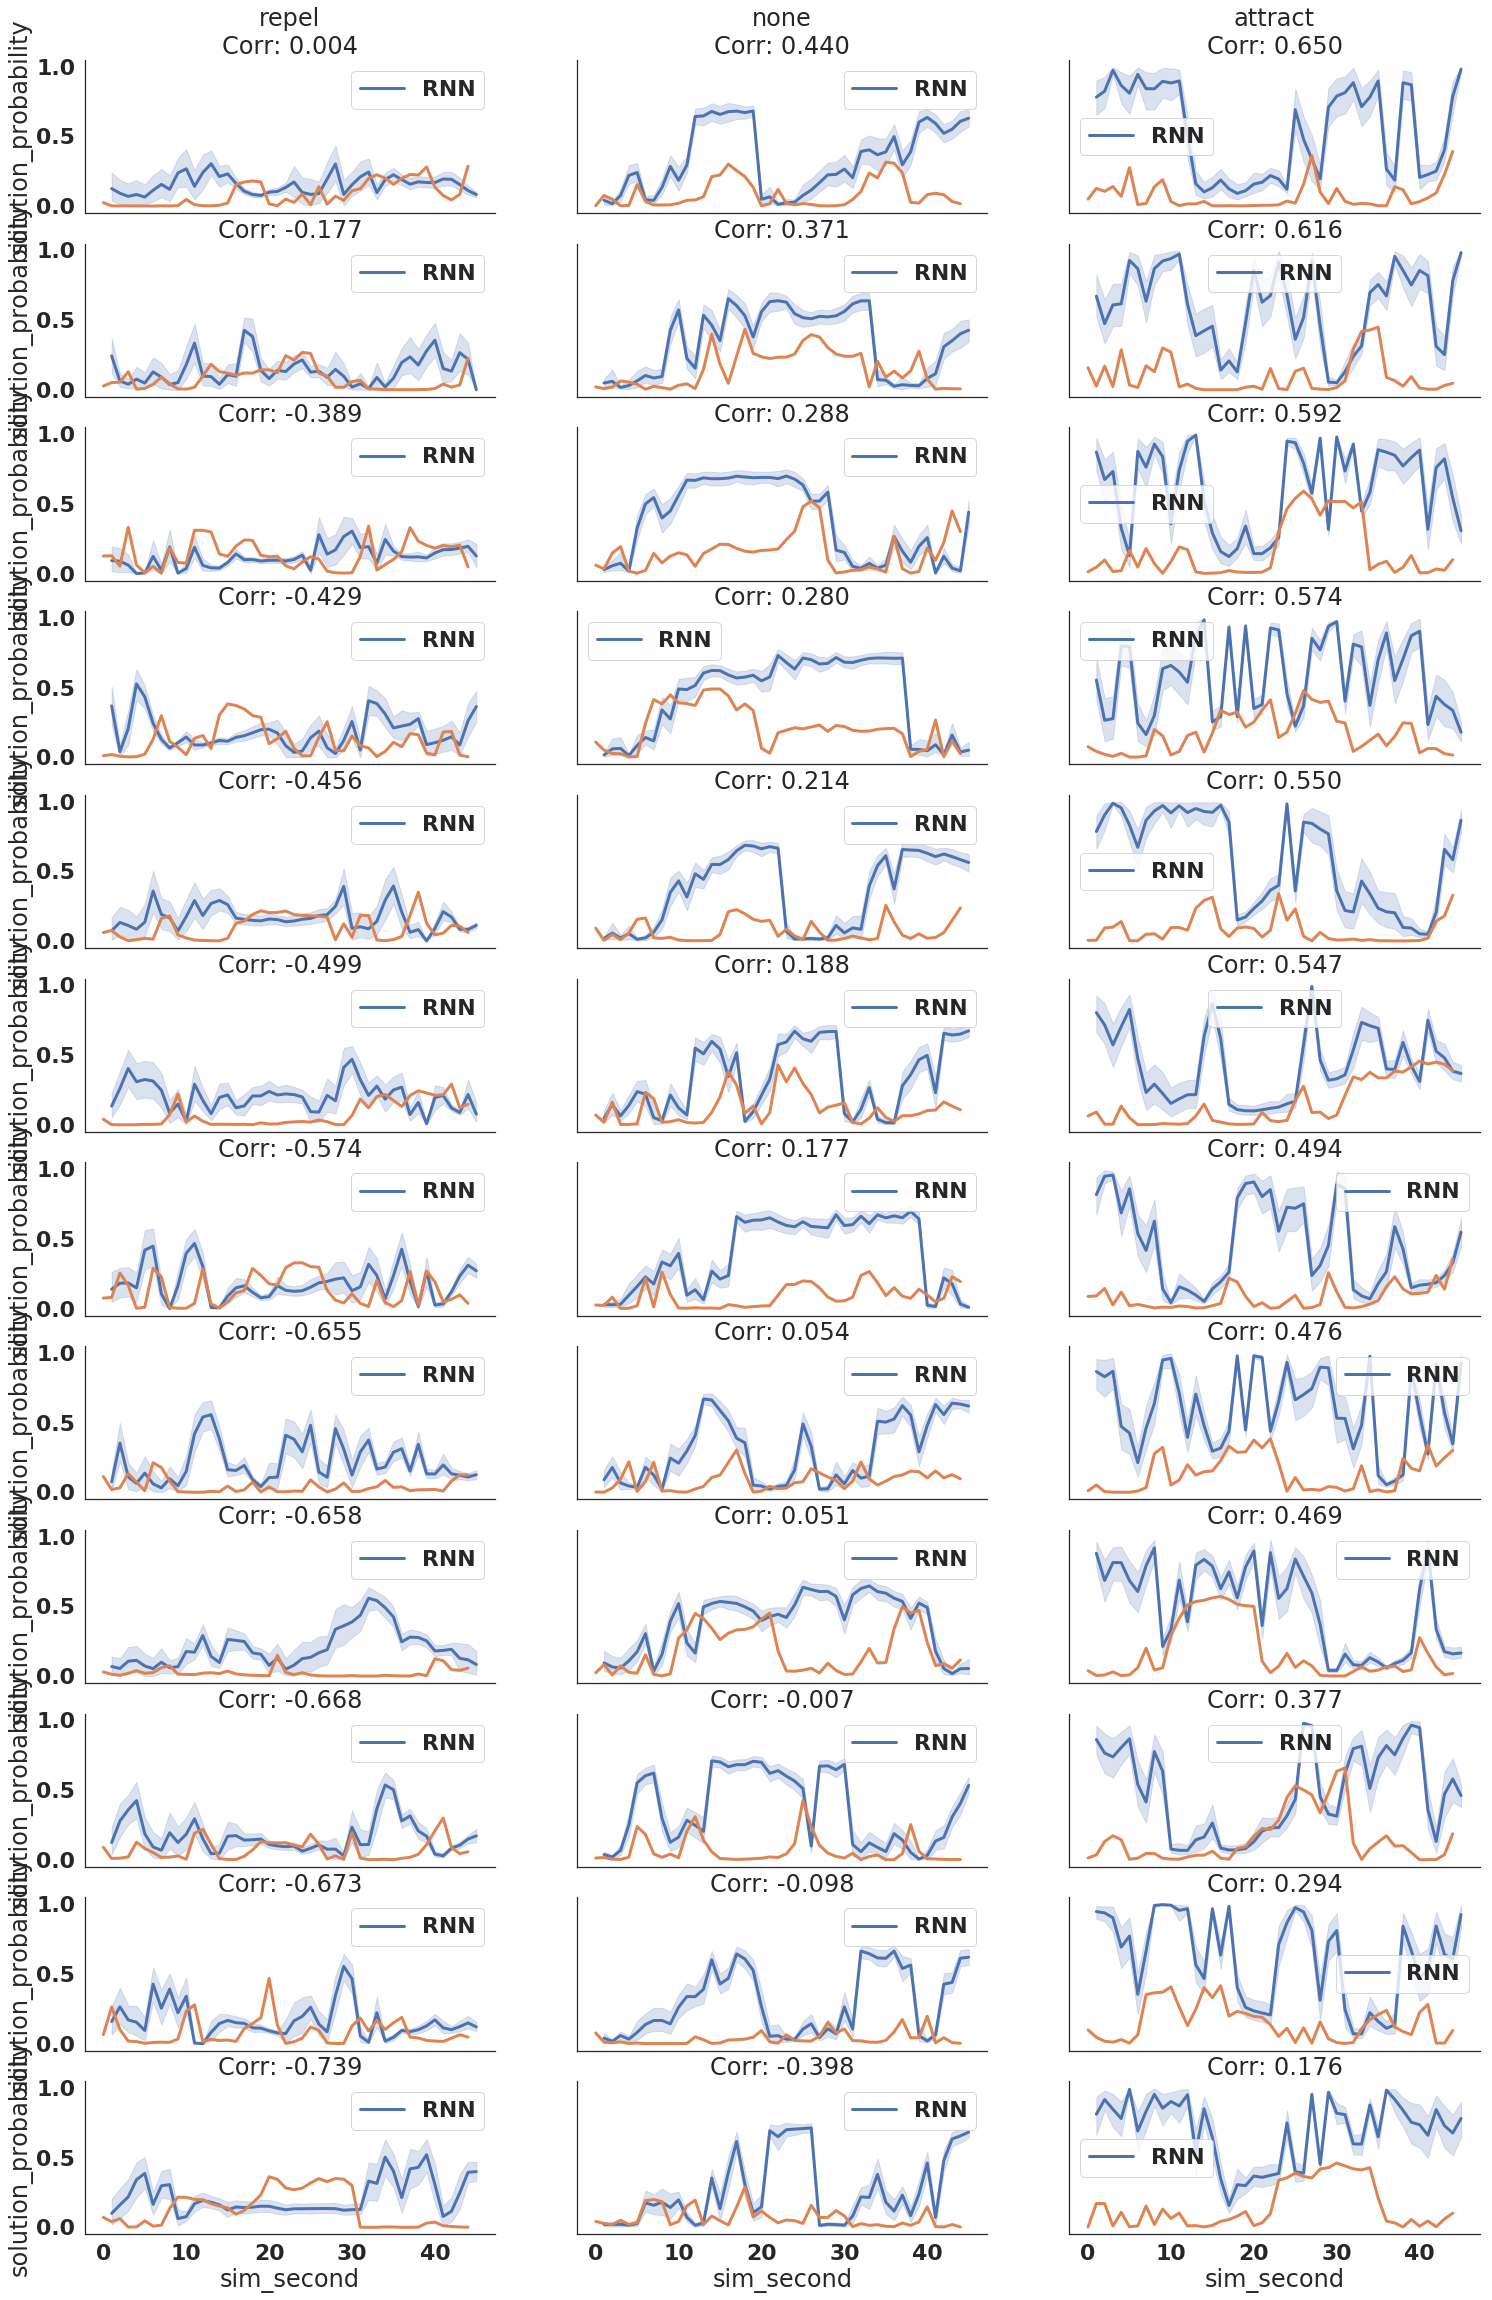

In [27]:
plot_appendix_figure(force_corr_df, force_models_and_trials)